In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
#import seaborn as sns

# Ensure plots display inline in Jupyter Notebook
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

In [32]:
def load_f1_data(year, data_folder="data"):
    """
    Loads and processes Formula 1 data from CSV files for a given year.
    
    Args:
        year (int): The year to filter races (e.g., 2023).
        data_folder (str): Path to the folder containing Kaggle dataset CSV files.
    
    Returns:
        pd.DataFrame: Processed data with race, driver, and qualifying info.
    """
    # Load CSV files
    try:
        results = pd.read_csv(f"{data_folder}/results.csv")
        races = pd.read_csv(f"{data_folder}/races.csv")
        drivers = pd.read_csv(f"{data_folder}/drivers.csv")
        qualifying = pd.read_csv(f"{data_folder}/qualifying.csv")
        
        # Print qualifying.csv columns to debug
        print(f"Columns in qualifying.csv: {qualifying.columns.tolist()}")
        
        # Filter races for the specified year
        races_year = races[races['year'] == year]
        
        # Merge results with races and drivers
        results_year = results[results['raceId'].isin(races_year['raceId'])]
        data = results_year.merge(races[['raceId', 'year', 'circuitId', 'name']], on='raceId')
        data = data.merge(drivers[['driverId', 'forename', 'surname']], on='driverId')
        data['driver'] = data['forename'] + ' ' + data['surname']
        
        # Merge with qualifying data (assuming 'position' is the column; adjust if needed)
        data = data.merge(qualifying[['raceId', 'driverId', 'position']], on=['raceId', 'driverId'], how='left')
        data = data.rename(columns={'position': 'qualifying_position'})
        
        # Check for missing qualifying data
        if 'qualifying_position' not in data.columns:
            print("Warning: 'qualifying_position' column not created. Adding default values.")
            data['qualifying_position'] = 20  # Default to last position
        else:
            print(f"Missing qualifying positions: {data['qualifying_position'].isna().sum()}")
            data['qualifying_position'] = data['qualifying_position'].fillna(20)  # Fill missing with last position
        
        return data
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load data for a sample year to check
year = 2024
data = load_f1_data(year)
if data is not None:
    print("Sample data:")
    display(data.head())  # Use display for better formatting in Jupyter

Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Sample data:


,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,fastestLapSpeed,statusId,year,circuitId,name,forename,surname,driver,position_y,qualifying_position
0,26286,1121,830,9,1,1,1,1,1,26.0,...,210.383,1,2024,3,Bahrain Grand Prix,Max,Verstappen,Max Verstappen,1,20
1,26287,1121,815,9,11,5,2,2,2,18.0,...,206.468,1,2024,3,Bahrain Grand Prix,Sergio,Pérez,Sergio Pérez,5,20
2,26288,1121,832,6,55,4,3,3,3,15.0,...,206.156,1,2024,3,Bahrain Grand Prix,Carlos,Sainz,Carlos Sainz,4,20
3,26289,1121,844,6,16,2,4,4,4,12.0,...,207.069,1,2024,3,Bahrain Grand Prix,Charles,Leclerc,Charles Leclerc,2,20
4,26290,1121,847,131,63,3,5,5,5,10.0,...,204.946,1,2024,3,Bahrain Grand Prix,George,Russell,George Russell,3,20


In [ ]:
def create_features(data, historical_data, year):
    """
    Creates features for prediction, such as driver form and track performance.
    
    Args:
        data (pd.DataFrame): Data for the target year.
        historical_data (pd.DataFrame): Data for prior years to compute stats.
        year (int): The target year.
    
    Returns:
        pd.DataFrame: Data with features and target.
    """
    if data is None or historical_data is None:
        print("Error: Input data is None")
        return None
    
    # Initialize feature columns
    data['driver_form'] = 0.0  # Average finishing position in last 5 races
    data['track_win_rate'] = 0.0  # Driver's win rate on this track
    data['qualifying_position'] = data['qualifying_position'].fillna(20)  # Ensure no NaN values
    
    # Create target: 1 if driver won, 0 otherwise
    data['winner'] = (data['positionOrder'] == 1).astype(int)
    
    for race_id in data['raceId'].unique():
        race_data = data[data['raceId'] == race_id]
        circuit_id = race_data['circuitId'].iloc[0]
        
        for driver_id in race_data['driverId']:
            # Driver's recent form (average finishing position in last 5 races)
            driver_races = historical_data[
                (historical_data['driverId'] == driver_id) & 
                (historical_data['year'] < year)
            ].sort_values('raceId').tail(5)
            if not driver_races.empty:
                avg_position = driver_races['positionOrder'].mean()
                data.loc[(data['raceId'] == race_id) & (data['driverId'] == driver_id), 'driver_form'] = avg_position
            
            # Driver's track win rate
            track_races = historical_data[
                (historical_data['circuitId'] == circuit_id) & 
                (historical_data['driverId'] == driver_id) & 
                (historical_data['year'] < year)
            ]
            if not track_races.empty:
                win_rate = (track_races['positionOrder'] == 1).mean()
                data.loc[(data['raceId'] == race_id) & (data['driverId'] == driver_id), 'track_win_rate'] = win_rate
    
    return data[['raceId', 'driverId', 'driver', 'name', 'qualifying_position', 'driver_form', 'track_win_rate', 'winner']]

# Load historical data (2010–2022) for feature engineering
historical_data = pd.concat([load_f1_data(y) for y in range(2010, 2024)])
train_data = create_features(load_f1_data(2024), historical_data, 2024)
if train_data is not None:
    print("Processed data with features:")
    display(train_data.head())  # Display to verify features

Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Columns in qualifying.csv: ['qualifyId',

,raceId,driverId,driver,name,qualifying_position,driver_form,track_win_rate,winner
0,1098,830,Max Verstappen,Bahrain Grand Prix,20,2.0,0.000000,1
1,1098,815,Sergio Pérez,Bahrain Grand Prix,20,3.8,0.083333,0
2,1098,4,Fernando Alonso,Bahrain Grand Prix,20,11.6,0.111111,0
3,1098,832,Carlos Sainz,Bahrain Grand Prix,20,10.2,0.000000,0
4,1098,1,Lewis Hamilton,Bahrain Grand Prix,20,5.8,0.416667,0


Evaluation Metrics for 2023:
Accuracy: 0.99
Precision: 0.75
Recall: 1.00
F1-Score: 0.86
ROC-AUC: 0.99
Log Loss: 0.06


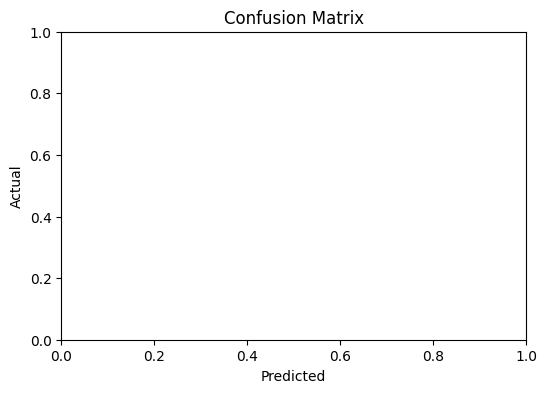

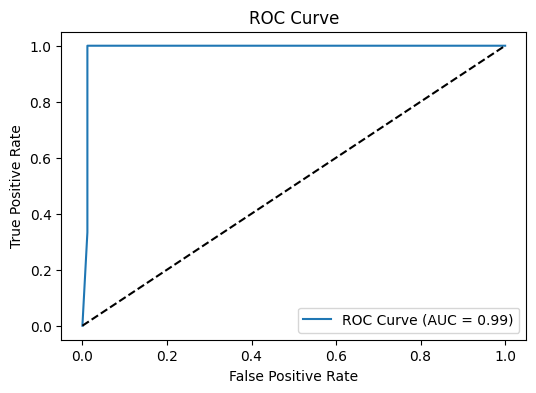

In [25]:
if train_data is not None:
    features = ['qualifying_position', 'driver_form', 'track_win_rate']
    X = train_data[features]
    y = train_data['winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    logloss = log_loss(y_test, y_pred_proba)
    
    print(f"Evaluation Metrics for {year}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"Log Loss: {logloss:.2f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [31]:
if train_data is not None:
    # Select a sample race from 2023 (e.g., first race in the dataset)
    sample_race = train_data[train_data['name'] == 'Singapore Grand Prix']  # Replace with desired race name
    sample_X = sample_race[features]
    sample_pred_proba = model.predict_proba(sample_X)[:, 1]  # Probability of winning

    # Display predictions
    sample_results = sample_race[['driver', 'name']].copy()
    sample_results['win_probability'] = sample_pred_proba
    sample_results = sample_results.sort_values('win_probability', ascending=False)
    print(f"\nPredicted probabilities for {sample_results['name'].iloc[0]}:")
    display(sample_results[['driver', 'win_probability']].head())


Predicted probabilities for Singapore Grand Prix:


,driver,win_probability
284,Max Verstappen,0.990000
280,Carlos Sainz,0.062059
287,Sergio Pérez,0.020741
281,Lando Norris,0.000000
283,Charles Leclerc,0.000000
